In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib as mpl

In [3]:
%cd C:\\Users\\Admin\\Documents\\4060\\final

C:\Users\Admin\Documents\4060\final


In [4]:
wtsm = sc.read_10x_mtx('./',prefix='GSM4852292_98170_')


kosm = sc.read_10x_mtx('./',prefix='GSM4852293_98171_')


In [5]:
wtsm

AnnData object with n_obs × n_vars = 6304 × 31053
    var: 'gene_ids', 'feature_types'

In [6]:
wtsm.write('write/wtsm.h5ad')
kosm.write('write/kosm.h5ad')

In [7]:
sc.pp.filter_cells(wtsm, min_genes=200)    #Cells expressing fewer than 200 or more than 5,000 unique genes and 
sc.pp.filter_cells(wtsm, max_genes=5000)   #cells with more than 7.5% mitochondrial content were discarded
sc.pp.filter_genes(wtsm, min_cells=3)
sc.pp.filter_cells(kosm, min_genes=200)
sc.pp.filter_cells(kosm, max_genes=5000)
sc.pp.filter_genes(kosm, min_cells=3)

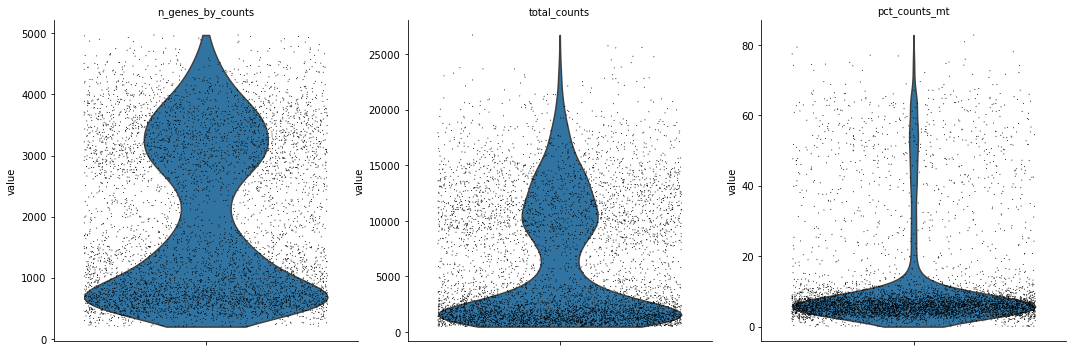

In [8]:
# data preprossing for wild type samples
wtsm.var['mt'] = wtsm.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(wtsm, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(wtsm, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [9]:
#filter out samples (cells) with more than 5000 experssion or less than 200 expression and more than 7.5% MT gene
wtsm = wtsm[wtsm.obs.pct_counts_mt < 7.5, :]

In [10]:
sc.pp.normalize_total(wtsm, target_sum=1e4)    #normalize cell with a scaling factor of 10000
sc.pp.log1p(wtsm)
sc.pp.highly_variable_genes(wtsm, flavor='seurat', n_top_genes=2000, inplace=True)    #choose the top 2000 variable genes

C:\ANACONDA\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [11]:
wtsm.raw = wtsm

In [12]:
# data preprossing for knock out samples
kosm.var['mt'] = kosm.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(kosm, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#filter out samples (cells) with more than 5000 experssion or less than 200 expression and more than 7.5% MT gene
kosm = kosm[kosm.obs.pct_counts_mt < 7.5, :]

In [13]:
sc.pp.normalize_total(kosm, target_sum=1e4)    #normalize cell with a scaling factor of 10000
sc.pp.log1p(kosm)
sc.pp.highly_variable_genes(kosm, flavor='seurat', n_top_genes=2000, inplace=True)    #choose the top 2000 variable genes

C:\ANACONDA\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [14]:
kosm.raw = kosm

In [15]:
wtsm

AnnData object with n_obs × n_vars = 3860 × 16194
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

In [16]:
wtsm.obs['treatment'] = 'WildType'    #label the treatment group

In [17]:
kosm.obs['treatment'] = 'KnockOut'

In [18]:
wtsm_cut = wtsm[:, wtsm.var.highly_variable]
kosm_cut = kosm[:, kosm.var.highly_variable]

In [19]:
sp_all = wtsm_cut.concatenate(kosm_cut)    #merge both treatment groups

C:\ANACONDA\lib\site-packages\anndata\_core\anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [20]:
sp_all

AnnData object with n_obs × n_vars = 7414 × 1198
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'treatment', 'batch'
    var: 'gene_ids', 'feature_types', 'mt', 'highly_variable', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'means-1', 'dispersions-1', 'dispersions_norm-1'

In [21]:
sc.pp.scale(sp_all, max_value=10)

In [22]:
sc.tl.pca(sp_all, svd_solver='arpack')

In [23]:
sc.pp.neighbors(sp_all, n_neighbors=15, n_pcs=20)


In [24]:
results_file = 'write/preprossedmerged.h5ad'  # the file that will store the analysis results
sp_all.write(results_file)

In [25]:
sc.tl.umap(sp_all, min_dist=0.5)

In [26]:
    sc.tl.leiden(sp_all,resolution=1.2)

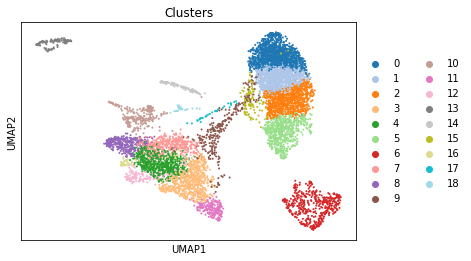

In [27]:
sc.pl.umap(
    sp_all, 
    color=['leiden'],
    palette='tab20', # 'palette' specifies the colormap to use)
    title=["Clusters"]
)

In [28]:
marker_genes = ['Tyr', 'Mlana', 'Pmel', 'Dct', 'Mitf', 'Ptgds', 'Cd68', 'Lyz2', 'Aif1', 'Dab2', 'Lgals3', 'Trem2', 'Apoe', 
               'Ccr7', 'H2-Eb1', 'H2-Aa', 'H2-Ab1', 'Ccl5', 'Cd3e', 'Cd3g', 'Nkg7', 'Cd3d', 'Gzma', 'Pecam1', 'Cdh5', 'Cd34', 
               'Flt1', 'Cldn5', 'Col1a1', 'Col1a2', 'Acta2', 'Dcn', 'Col3a1', 'Pdgfrb', 'Pdpn', 'Irf8', 'Ccr9', 'Plac8',
                'Bst2']

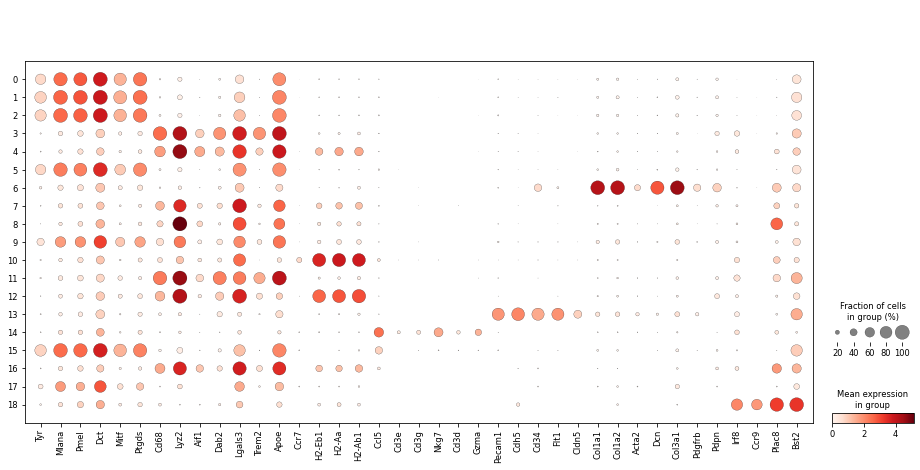

In [29]:
sc.pl.dotplot(sp_all, marker_genes, groupby='leiden')

In [30]:
sp_all

AnnData object with n_obs × n_vars = 7414 × 1198
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'treatment', 'batch', 'leiden'
    var: 'gene_ids', 'feature_types', 'mt', 'highly_variable', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [75]:
sp_all.obs['annotation'] = 'haha'

In [76]:
pd.options.mode.chained_assignment = None 
for i in range(len(sp_all.obs['leiden'])):
    if int(sp_all.obs['leiden'][i]) == 5:
        sp_all.obs['annotation'][i] = 'Melanoma cells'
    elif int(sp_all.obs['leiden'][i]) == 9:
        sp_all.obs['annotation'][i] = 'Melanoma cells'
    elif int(sp_all.obs['leiden'][i]) == 15:
        sp_all.obs['annotation'][i] = 'Melanoma cells'
    elif int(sp_all.obs['leiden'][i]) == 17:
        sp_all.obs['annotation'][i] = 'Melanoma cells'
    elif (0 <= int(sp_all.obs['leiden'][i]) and int(sp_all.obs['leiden'][i])<= 2):
        sp_all.obs['annotation'][i] = 'Melanoma cells'
    elif int(sp_all.obs['leiden'][i]) == 6:
        sp_all.obs['annotation'][i] = 'CAFs'
    elif int(sp_all.obs['leiden'][i]) == 18:
        sp_all.obs['annotation'][i] = 'Leukocytes'
    elif int(sp_all.obs['leiden'][i]) == 3:
        sp_all.obs['annotation'][i] = 'TAMs'
    elif int(sp_all.obs['leiden'][i]) == 4:
        sp_all.obs['annotation'][i] = 'TAMs'
    elif int(sp_all.obs['leiden'][i]) == 7:
        sp_all.obs['annotation'][i] = 'TAMs'
    elif int(sp_all.obs['leiden'][i]) == 8:
        sp_all.obs['annotation'][i] = 'TAMs'
    elif int(sp_all.obs['leiden'][i]) == 11:
        sp_all.obs['annotation'][i] = 'TAMs'
    elif int(sp_all.obs['leiden'][i]) == 16:
        sp_all.obs['annotation'][i] = 'TAMs'
    elif int(sp_all.obs['leiden'][i]) == 10:
        sp_all.obs['annotation'][i] = 'TAMs/dendtirics'
    elif int(sp_all.obs['leiden'][i]) == 12:
        sp_all.obs['annotation'][i] = 'TAMs/dendtirics'
    elif int(sp_all.obs['leiden'][i]) == 14:
        sp_all.obs['annotation'][i] = 'T/NK cells'
    elif int(sp_all.obs['leiden'][i]) == 13:
        sp_all.obs['annotation'][i] = 'Endothelial cells'

In [77]:
if 'haha' in sp_all.obs['annotation']:
    print('oops')
else:
    print('yeah')

yeah


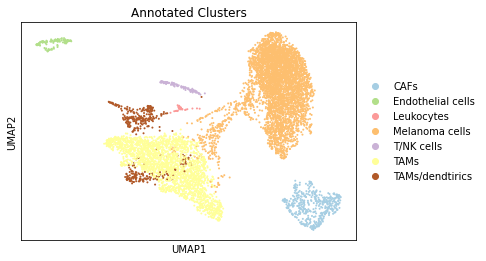

In [80]:
sc.pl.umap(
    sp_all, 
    color=['annotation'],
    palette='Paired', # 'palette' specifies the colormap to use)
    title=["Annotated Clusters"]
)

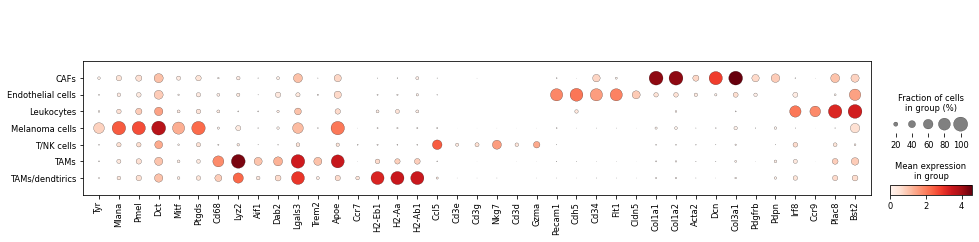

In [81]:
sc.pl.dotplot(sp_all, marker_genes, groupby='annotation')

In [36]:
sp_all.write('write/small_all_annotated.h5ad')

In [37]:
sp_CAF = sp_all[sp_all.obs.annotation == 'CAFs', :]

In [38]:
sp_CAF

View of AnnData object with n_obs × n_vars = 471 × 1198
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'treatment', 'batch', 'leiden', 'annotation'
    var: 'gene_ids', 'feature_types', 'mt', 'highly_variable', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'mean', 'std'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'annotation_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [39]:
df_violin = sc.get.obs_df(sp_CAF, ['Acta2', 'Pdgfrb', 'Col1a1', 'Col1a2', 'treatment'])


In [40]:
df_violin = df_violin.set_index('treatment').stack().reset_index()

<AxesSubplot:xlabel='gene', ylabel='value'>

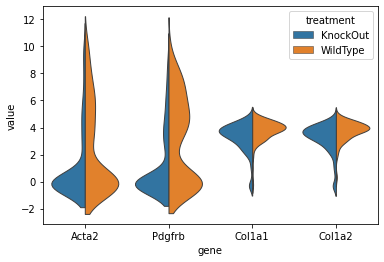

In [41]:
df_violin.columns = ['treatment', 'gene', 'value']
import seaborn as sns
sns.violinplot(data=df_violin, x='gene', y='value', hue="treatment",
                split=True, inner=None, linewidth=1, scale = 'width')    

In [124]:
df_violin_chart = sc.get.obs_df(sp_CAF, ['Acta2', 'Pdgfrb', 'Col1a1', 'Col1a2', 'treatment'])
df_violin_chart

,Acta2,Pdgfrb,Col1a1,Col1a2,treatment
AAAGGATAGTGTTGAA-1-0,-0.161608,-0.176917,3.742195,3.688825,WildType
AAAGGGCCAGGCTCTG-1-0,-0.161608,10.000000,4.926221,4.811593,WildType
AACACACTCCTAGCCT-1-0,-0.161608,-0.176917,3.215020,2.740236,WildType
AACCATGGTTCCTACC-1-0,-0.161608,-0.176917,4.430164,4.242853,WildType
AACCTTTAGTGGCAGT-1-0,5.727463,3.723222,3.624766,3.694466,WildType
...,...,...,...,...,...
TTTGATCAGAATTTGG-1-1,-0.161608,-0.176917,4.565988,4.278287,KnockOut
TTTGGAGGTACAGGTG-1-1,-0.161608,-0.176917,3.916073,3.817718,KnockOut
TTTGGTTAGGAACGTC-1-1,-0.161608,-0.176917,2.359458,2.564836,KnockOut
TTTGGTTGTACCACGC-1-1,-0.161608,4.914633,3.197379,4.028831,KnockOut


In [127]:
df_violin_chart.groupby(by='treatment').mean()

,Acta2,Pdgfrb,Col1a1,Col1a2
treatment,,,,
KnockOut,1.137959,1.220551,3.281058,3.217840
WildType,2.371668,3.082690,3.782618,3.752836


In [65]:
sp_all.obs['DEGset'] = 'haha'

In [66]:
for i in range(len(sp_all.obs['annotation'])):
    if sp_all.obs['annotation'][i] == 'CAFs':
        if sp_all.obs['treatment'][i] == 'WildType':
            sp_all.obs['DEGset'][i] = 'CAF_WT'
        else: 
            sp_all.obs['DEGset'][i] = 'CAF_KO'
    else: 
        if sp_all.obs['treatment'][i] == 'WildType':
            sp_all.obs['DEGset'][i] = 'WT_Control'
        else: 
            sp_all.obs['DEGset'][i] = 'KO_Control'

In [98]:
#Defferential Expressed Gene Analysis for CAFs
        sc.tl.rank_genes_groups(sp_all, 'DEGset', groups=["CAF_WT"],method='wilcoxon', reference = 'CAF_KO')


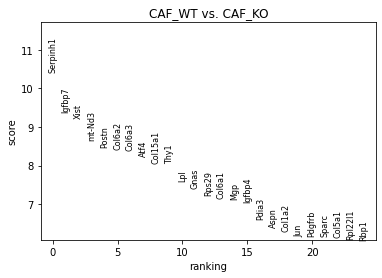

In [99]:
sc.pl.rank_genes_groups(sp_all, n_genes=25, sharey=False)

In [100]:
# get deg result
result = sp_all.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_WT = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [101]:
degs_WT

,CAF_WT_names,CAF_WT_scores,CAF_WT_pvals,CAF_WT_pvals_adj,CAF_WT_logfoldchanges
0,Serpinh1,10.410378,2.223393e-25,1.733802e-21,1.179403
1,Igfbp7,9.372261,7.099527e-21,1.845404e-17,1.672786
2,Xist,9.237401,2.525577e-20,5.626985e-17,2.247316
3,mt-Nd3,8.667727,4.408297e-18,6.875180e-15,1.352702
4,Postn,8.475459,2.341551e-17,3.319893e-14,1.436628
...,...,...,...,...,...
15591,Rpl12,-9.064155,1.255739e-19,2.448063e-16,-0.652307
15592,Rarres2,-9.385849,6.241178e-21,1.845404e-17,-2.348104
15593,Rps12,-9.519690,1.736972e-21,6.772452e-18,-0.521985
15594,Mt1,-10.100233,5.511108e-24,2.865042e-20,-2.036879


In [102]:
sc.tl.rank_genes_groups(sp_all, 'DEGset', groups=["CAF_KO"],method='wilcoxon', reference = 'CAF_WT')


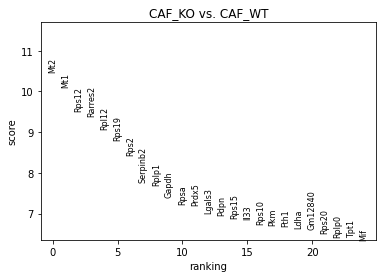

In [103]:
sc.pl.rank_genes_groups(sp_all, n_genes=25, sharey=False)

In [104]:
# get deg result
result = sp_all.uns['rank_genes_groups']
groups = result['names'].dtype.names
degs_KO = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names','scores', 'pvals','pvals_adj','logfoldchanges']})

In [105]:
degs_KO

,CAF_KO_names,CAF_KO_scores,CAF_KO_pvals,CAF_KO_pvals_adj,CAF_KO_logfoldchanges
0,Mt2,10.465408,1.245387e-25,1.733802e-21,2.363391
1,Mt1,10.100233,5.511108e-24,2.865042e-20,2.036879
2,Rps12,9.519690,1.736972e-21,6.772452e-18,0.521985
3,Rarres2,9.385849,6.241178e-21,1.845404e-17,2.348104
4,Rpl12,9.064155,1.255739e-19,2.448063e-16,0.652307
...,...,...,...,...,...
15591,Postn,-8.475459,2.341551e-17,3.319893e-14,-1.436628
15592,mt-Nd3,-8.667727,4.408297e-18,6.875180e-15,-1.352702
15593,Xist,-9.237401,2.525577e-20,5.626985e-17,-2.247316
15594,Igfbp7,-9.372261,7.099527e-21,1.845404e-17,-1.672786


In [106]:
# subset up or down regulated genes
degs_WT_sig = degs_WT[degs_WT.CAF_WT_pvals_adj < 0.05]
degs_WT_up = degs_WT_sig[degs_WT_sig.CAF_WT_logfoldchanges > 0]
degs_WT_dw = degs_WT_sig[degs_WT_sig.CAF_WT_logfoldchanges < 0]

In [107]:
degs_WT_up.shape

(132, 5)

In [108]:
degs_KO_sig = degs_KO[degs_KO.CAF_KO_pvals_adj < 0.05]
degs_KO_up = degs_KO_sig[degs_KO_sig.CAF_KO_logfoldchanges > 0]
degs_KO_dw = degs_KO_sig[degs_KO_sig.CAF_KO_logfoldchanges < 0]

In [109]:
degs_KO_up.shape

(105, 5)

In [110]:
import gseapy as gp
gp.__version__

'1.0.2'

In [111]:
# Enricr API
enr_WT_up = gp.enrichr(degs_WT_up.CAF_WT_names,
                    gene_sets='GO_Biological_Process_2021',
                       organism='Mouse',
                    outdir=None)

In [112]:
enr_KO_up = gp.enrichr(degs_KO_up.CAF_KO_names,
                    gene_sets='GO_Biological_Process_2021',
                       organism='Mouse',
                    outdir=None)

In [113]:
enr_WT_up.res2d.Term = enr_WT_up.res2d.Term.str.split(" \(GO").str[0]

In [114]:
enr_KO_up.res2d.Term = enr_KO_up.res2d.Term.str.split(" \(GO").str[0]

In [115]:
import matplotlib as plt

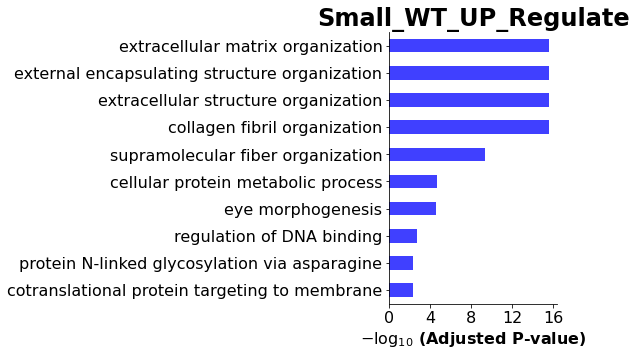

In [121]:
ax = gp.barplot(enr_WT_up.res2d.head(10), figsize=(3,5),title ="Small_WT_UP_Regulate", color = ['blue'])

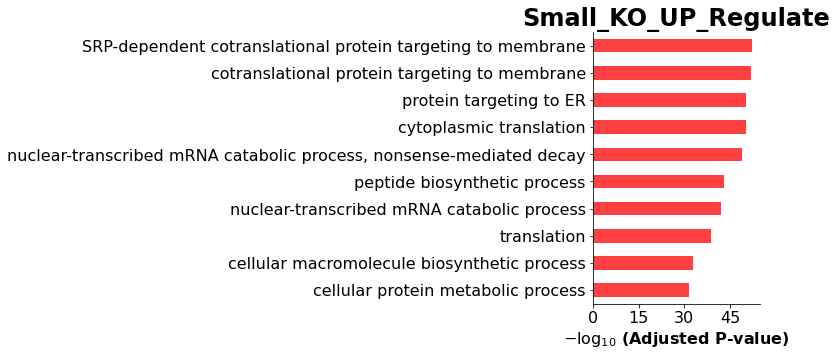

In [120]:
ax = gp.barplot(enr_KO_up.res2d.head(10), figsize=(3,5),title ="Small_KO_UP_Regulate", color = ['red'])

In [122]:
sc.__version__

'1.9.1'